In [1]:
from IPython.display import display
from IPython.display import Latex
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pytz
import pickle
import os
import pandas as pd

FSIZE = "full" #"tiny", "small" or "full"

fdir = os.path.join('pickles', 'temporal_analysis')
os.makedirs(fdir, exist_ok = True)

with open(os.path.join(fdir, f'decomposition-{FSIZE}-hourly.p'), 'rb') as f:
    decomp_hourly = pickle.load(f)

with open(os.path.join(fdir, f'decomposition-{FSIZE}-daily.p'), 'rb') as f:
    decomp_daily = pickle.load(f)

In [2]:
from notebook_shared import decomposeutils as dcu
from notebook_shared import utils
from notebook_shared import violinplotutil

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

In [3]:
aws_hourly_decomposes = list(filter(lambda decomp: decomp['provider'] == "AWS", decomp_hourly))
azure_hourly_decomposes = list(filter(lambda decomp: decomp['provider'] == "AZURE", decomp_hourly))
gcp_hourly_decomposes = list(filter(lambda decomp: decomp['provider'] == "GCP", decomp_hourly))

aws_daily_decomposes = list(filter(lambda decomp: decomp['provider'] == "AWS", decomp_daily))
azure_daily_decomposes = list(filter(lambda decomp: decomp['provider'] == "AZURE", decomp_daily))
gcp_daily_decomposes = list(filter(lambda decomp: decomp['provider'] == "GCP", decomp_daily))

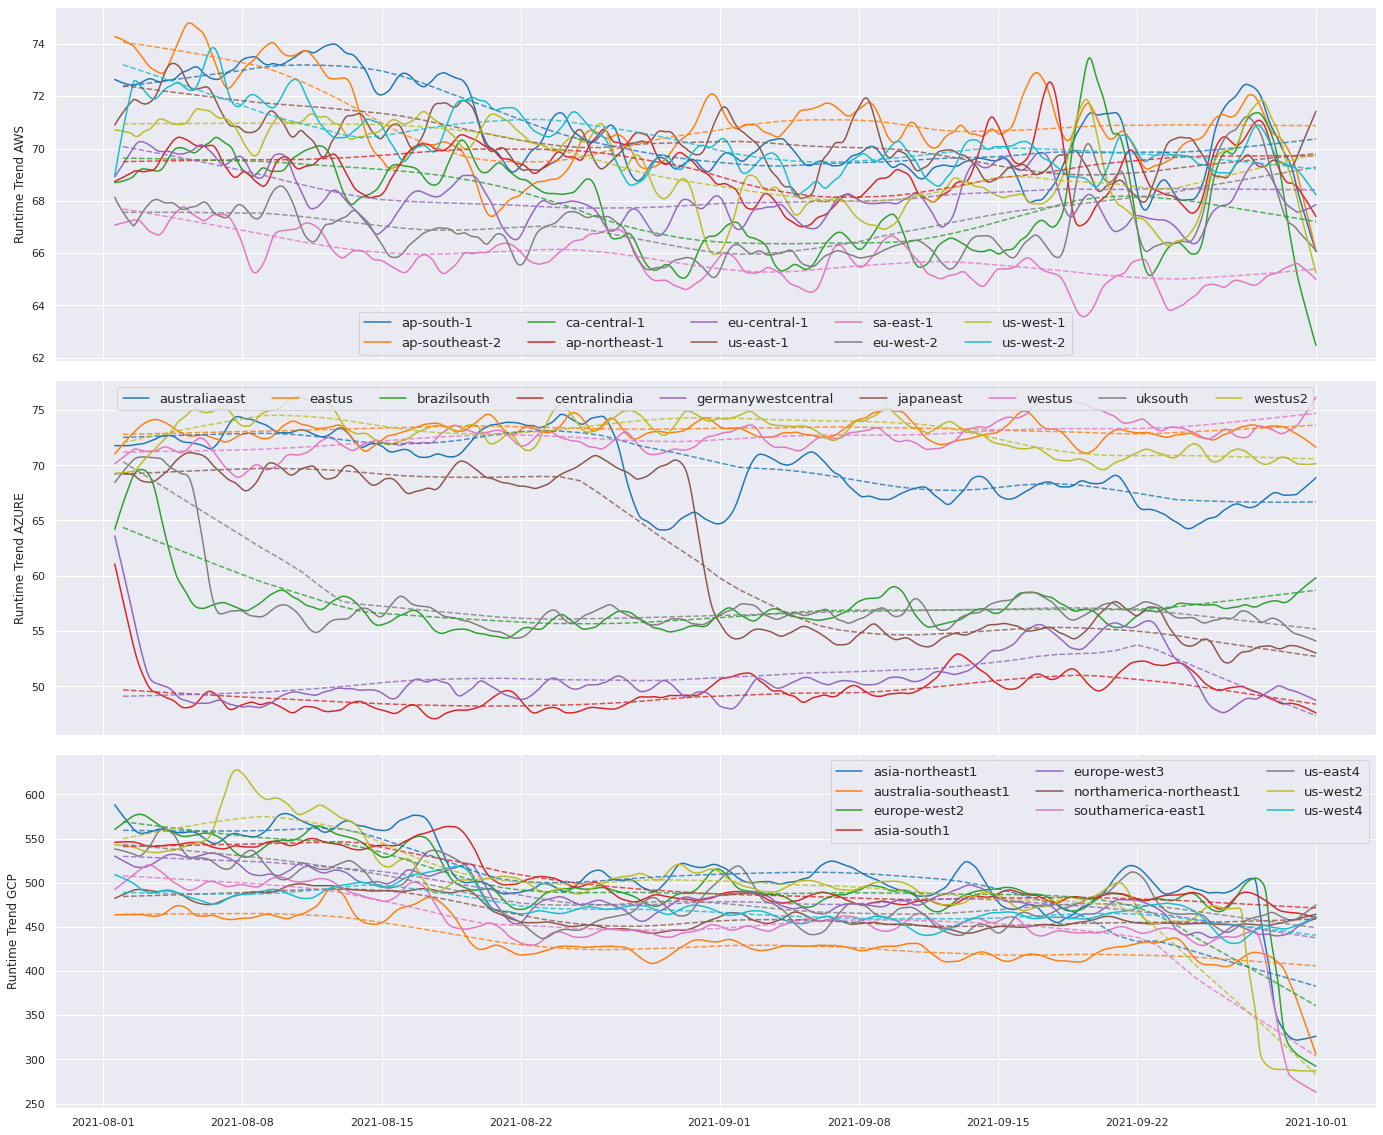

In [4]:
fig, axis = plt.subplots(figsize=(20,16), nrows=3, sharex=True)
sns.set(font_scale=1.2)
ax = axis[0]
for decomp in aws_hourly_decomposes:
    region = decomp['region']
    x= decomp['result']['decompositon']['data'].trend
    ax.plot(x, label=region, color=utils.provider_region_colors(region))
for decomp in aws_daily_decomposes:
    region = decomp['region']
    x= decomp['result']['decompositon']['data'].trend
    ax.plot(x, linestyle='dashed', color=utils.provider_region_colors(region), alpha=0.8)
leg = ax.legend(ncol=5, loc='lower center')
ax.set_ylabel('Runtime Trend AWS')

ax = axis[1]
for decomp in azure_hourly_decomposes:
    region = decomp['region']
    x= decomp['result']['decompositon']['data'].trend
    ax.plot(x, label=region, color=utils.provider_region_colors(region))
for decomp in azure_daily_decomposes:
    region = decomp['region']
    x= decomp['result']['decompositon']['data'].trend
    ax.plot(x, linestyle='dashed', color=utils.provider_region_colors(region), alpha=0.8)
ax.set_ylabel('Runtime Trend AZURE')
leg = ax.legend(ncol=10, loc='upper center')

ax = axis[2]
for decomp in gcp_hourly_decomposes:
    region = decomp['region']
    x= decomp['result']['decompositon']['data'].trend
    ax.plot(x, label=region, color=utils.provider_region_colors(region))
for decomp in gcp_daily_decomposes:
    region = decomp['region']
    x= decomp['result']['decompositon']['data'].trend
    ax.plot(x, linestyle='dashed', color=utils.provider_region_colors(region), alpha=0.8)
ax.set_ylabel('Runtime Trend GCP')

leg = ax.legend(ncol=3, loc='upper right')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_trend_overview'])

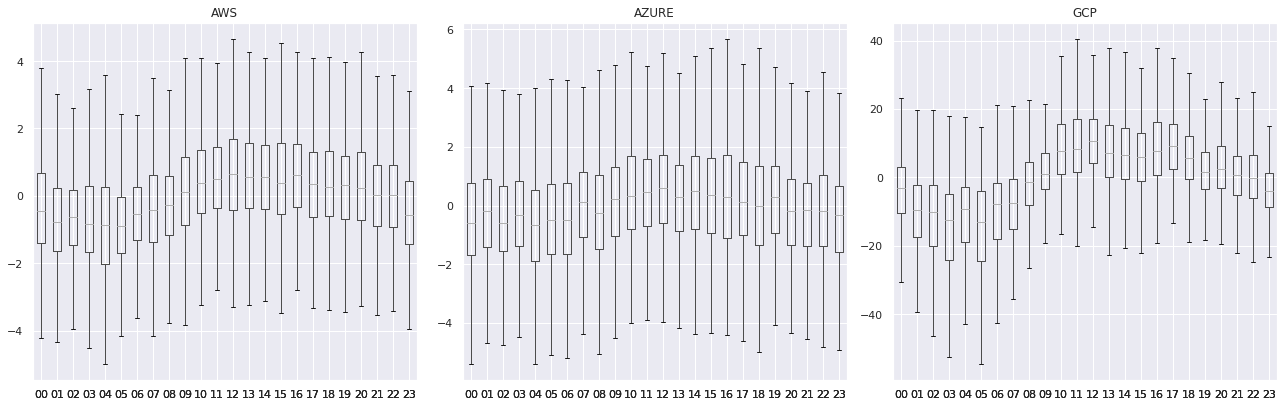

In [123]:
def boxplot_hourly(data, ax, title, col='seasonal'):
    fdf = None
    for decomp in data:
        timezone = decomp['timezone']
        region = decomp['region']
        
        if col == 'observed':
            series = getattr(decomp['result']['decompositon']['data'], col)['runtime'].rename(col)
        else:
            series = getattr(decomp['result']['decompositon']['data'], col).rename(col)
        
        df = pd.DataFrame(series)
        df.set_index(pd.DatetimeIndex(df.index), drop=False, inplace=False)
        df['hist'] = df.index.tz_localize('UTC').tz_convert(timezone).strftime("%H")
        
        if fdf is None:
            fdf = df
        else:
            fdf = fdf.append(df)  
    
    bxp = fdf.boxplot(col, by='hist', showfliers=False, ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel('')
    
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

boxplot_hourly(aws_hourly_decomposes, ax[0], 'AWS')
boxplot_hourly(azure_hourly_decomposes, ax[1], 'AZURE')
boxplot_hourly(gcp_hourly_decomposes, ax[2], 'GCP')
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_hourly_overview'])

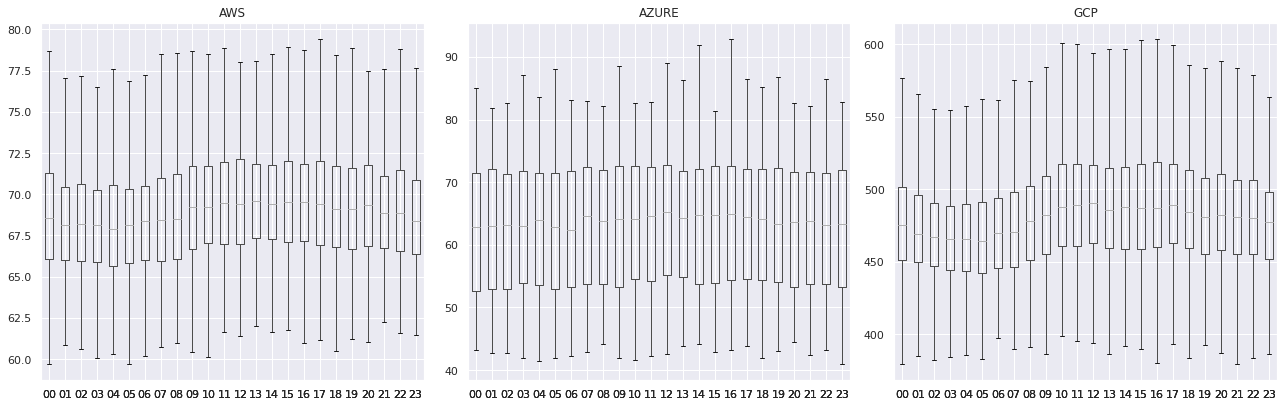

In [124]:
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

boxplot_hourly(aws_hourly_decomposes, ax[0], 'AWS', 'observed')
boxplot_hourly(azure_hourly_decomposes, ax[1], 'AZURE', 'observed')
boxplot_hourly(gcp_hourly_decomposes, ax[2], 'GCP', 'observed')
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_observed_hourly_overview'])

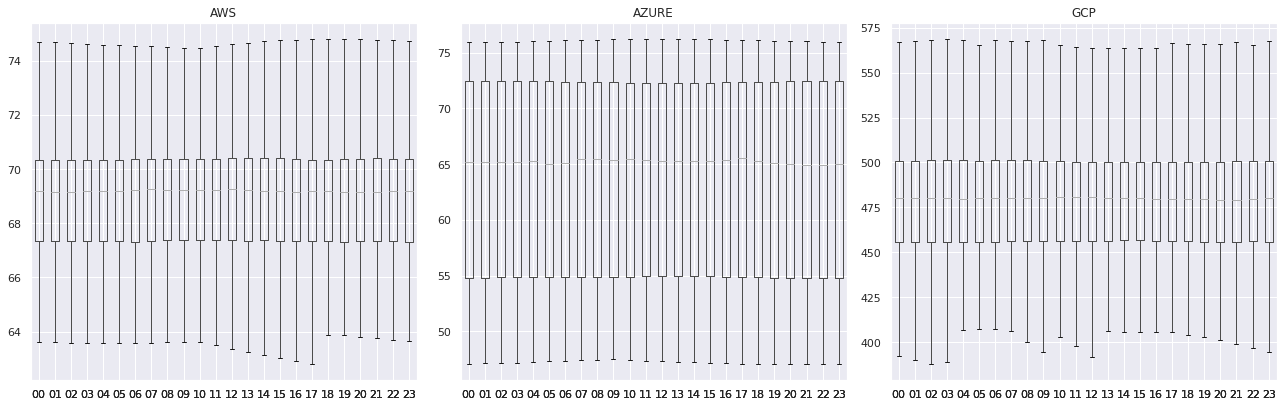

In [126]:
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

boxplot_hourly(aws_hourly_decomposes, ax[0], 'AWS', 'trend')
boxplot_hourly(azure_hourly_decomposes, ax[1], 'AZURE', 'trend')
boxplot_hourly(gcp_hourly_decomposes, ax[2], 'GCP', 'trend')
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_trend_hourly_overview'])

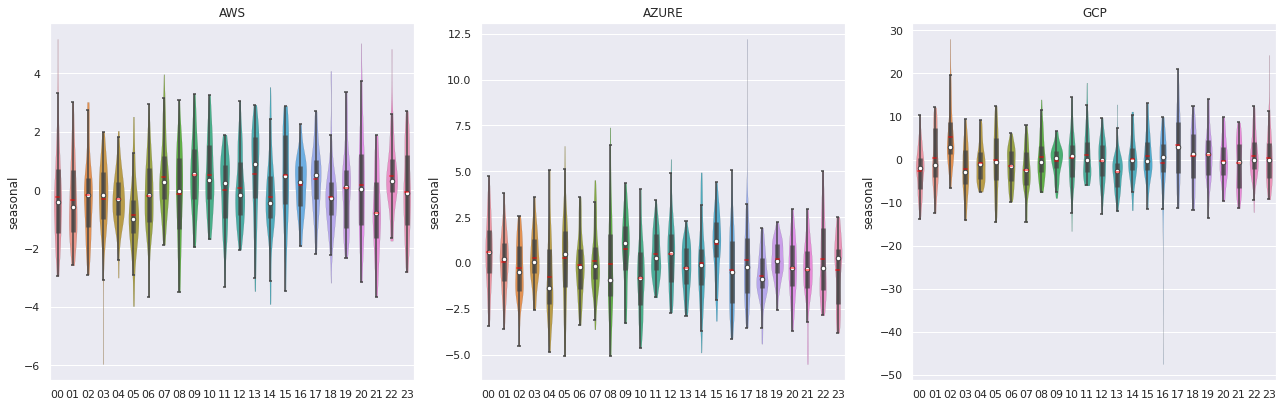

In [128]:
def violinplot_hourly(data, ax, title, col='seasonal'):
    fdf = None
    for decomp in data:
        timezone = decomp['timezone']
        region = decomp['region']
        
        if col == 'observed':
            series = getattr(decomp['result']['decompositon']['data'], col)['runtime'].rename(col)
        else:
            series = getattr(decomp['result']['decompositon']['data'], col).rename(col)
        
        df = pd.DataFrame(series)
        df.set_index(pd.DatetimeIndex(df.index), drop=False, inplace=False)
        df['hist'] = df.index.tz_localize('UTC').tz_convert(timezone).strftime("%H")

        if fdf is None:
            fdf = df
        else:
            fdf = fdf.append(df)  
    
    fdf = pd.DataFrame(fdf.to_dict())
    fdf = df.sort_values(by=['hist', col])
    ax = violinplotutil.violinplot(x="hist", y=col, cut=0, data=fdf, ax=ax, inner='box', rot=45, linewidth=0.1, customlineswidth=1.5)
    
    ax.set_title(title)
    ax.set_xlabel('')
    
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

violinplot_hourly(aws_hourly_decomposes, ax[0], 'AWS')
violinplot_hourly(azure_hourly_decomposes, ax[1], 'AZURE')
violinplot_hourly(gcp_hourly_decomposes, ax[2], 'GCP')
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_hourly_overview'])

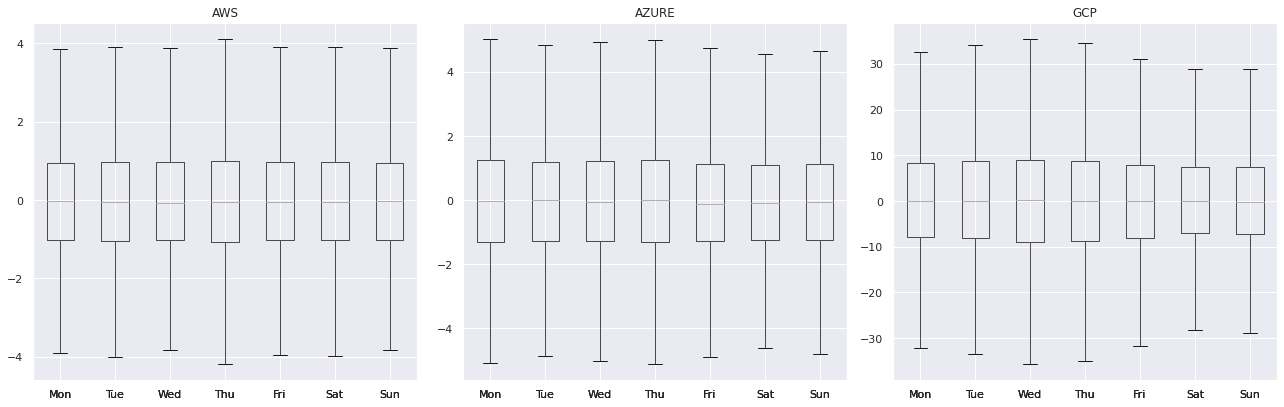

In [130]:
def boxplot_daily(data, ax, title, col='seasonal'):
    fdf = None
    for decomp in data:
        timezone = decomp['timezone']
        region = decomp['region']
        
        if col == 'observed':
            series = getattr(decomp['result']['decompositon']['data'], col)['runtime'].rename(col)
        else:
            series = getattr(decomp['result']['decompositon']['data'], col).rename(col)
        
        df = pd.DataFrame(series)
        df.set_index(pd.DatetimeIndex(df.index), drop=False, inplace=False)
        df['hist'] = df.index.tz_localize('UTC').tz_convert(timezone).strftime("%w")
    
        if fdf is None:
            fdf = df
        else:
            fdf = fdf.append(df)  
    fdf['hist'] = fdf['hist'].replace('0', '7')
    
    bxp = fdf.boxplot(col, by='hist', showfliers=False, ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel('')
    
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

boxplot_daily(aws_hourly_decomposes, ax[0], 'AWS')
boxplot_daily(azure_hourly_decomposes, ax[1], 'AZURE')
boxplot_daily(gcp_hourly_decomposes, ax[2], 'GCP')

# Plot Weekdays
ax[0].set_xticklabels(3*['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_daily_overview'])

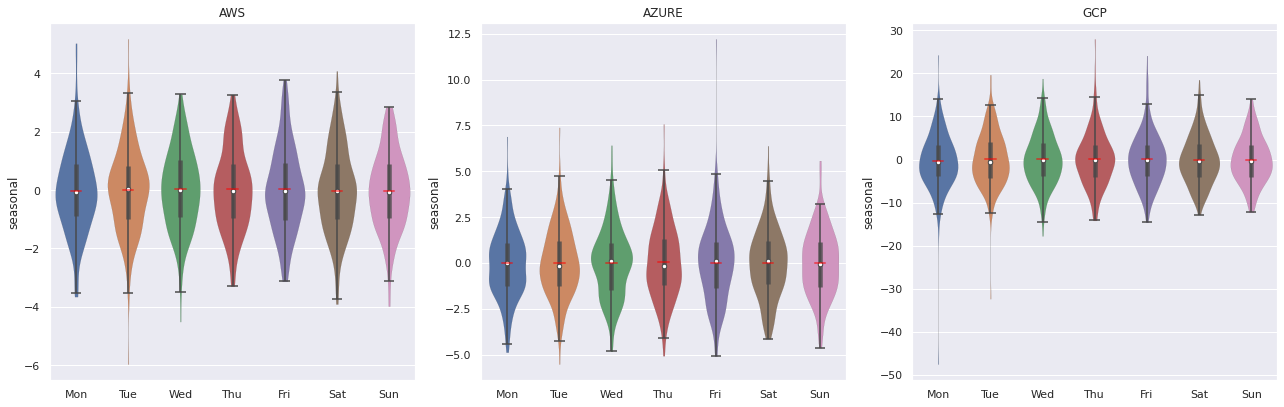

In [131]:
def violinplot_daily(data, ax, title, col='seasonal'):
    fdf = None
    for decomp in data:
        timezone = decomp['timezone']
        region = decomp['region']
        
        if col == 'observed':
            series = getattr(decomp['result']['decompositon']['data'], col)['runtime'].rename(col)
        else:
            series = getattr(decomp['result']['decompositon']['data'], col).rename(col)
        
        df = pd.DataFrame(series)
        df.set_index(pd.DatetimeIndex(df.index), drop=False, inplace=False)
        df['hist'] = df.index.tz_localize('UTC').tz_convert(timezone).strftime("%w")
    
        if fdf is None:
            fdf = df
        else:
            fdf = fdf.append(df)  
    fdf['hist'] = fdf['hist'].replace('0', '7')
    
    fdf = pd.DataFrame(fdf.to_dict())
    fdf = df.sort_values(by=['hist', col])
    ax = violinplotutil.violinplot(x="hist", y=col, cut=0, data=fdf, ax=ax, inner='box', rot=45, linewidth=0.1, customlineswidth=1.5)
    
    ax.set_title(title)
    ax.set_xlabel('')
    
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

violinplot_daily(aws_hourly_decomposes, ax[0], 'AWS')
violinplot_daily(azure_hourly_decomposes, ax[1], 'AZURE')
violinplot_daily(gcp_hourly_decomposes, ax[2], 'GCP')

# Plot Weekdays
ax[0].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_daily_overview_violin'])

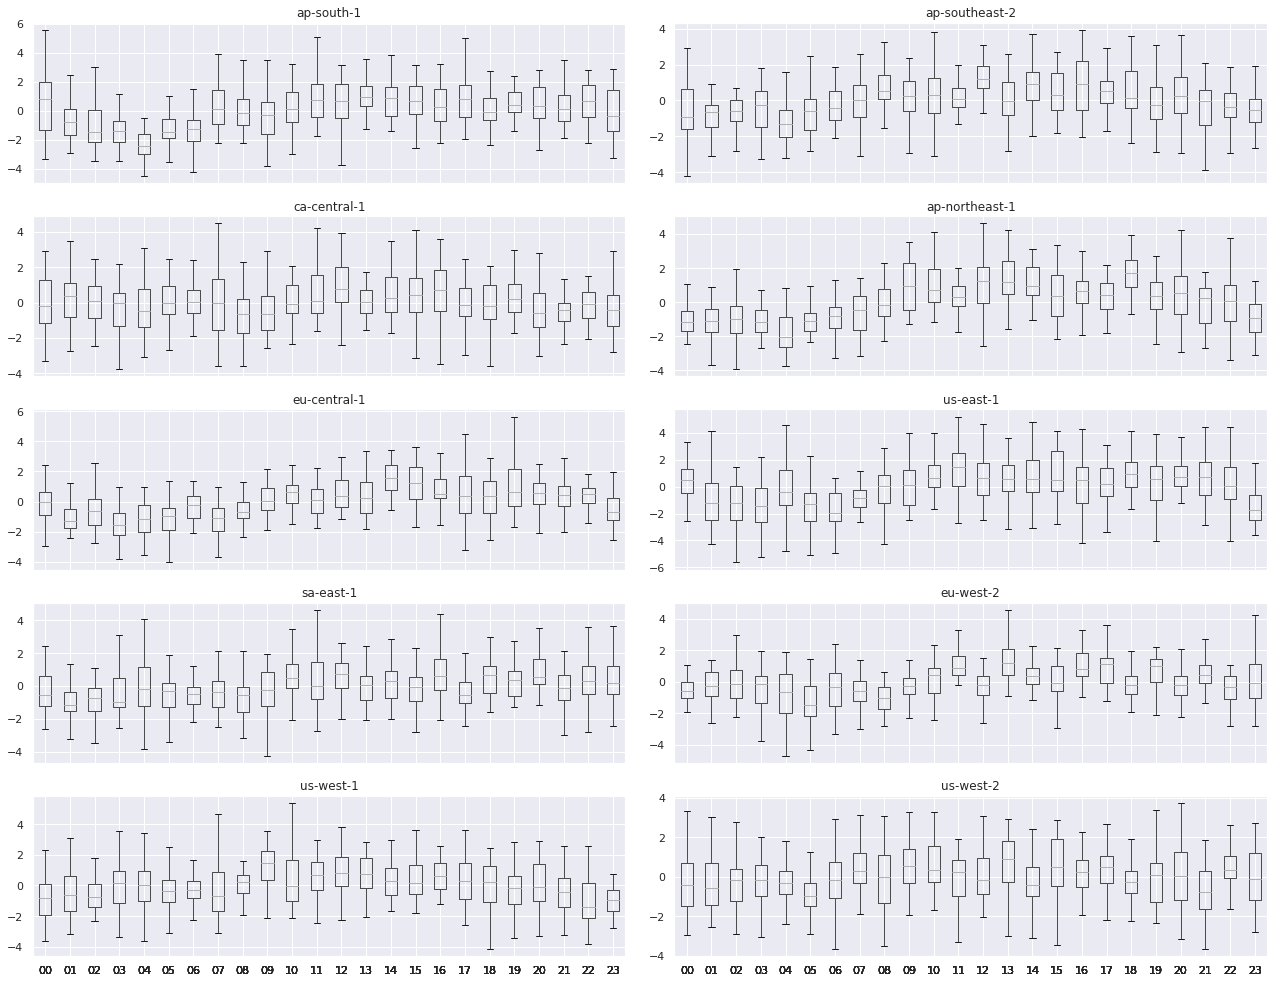

In [132]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)
from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in aws_hourly_decomposes:
    boxplot_hourly([decomp], axis[cax], decomp['region'])
    cax += 1
    
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_hourly_aws'])

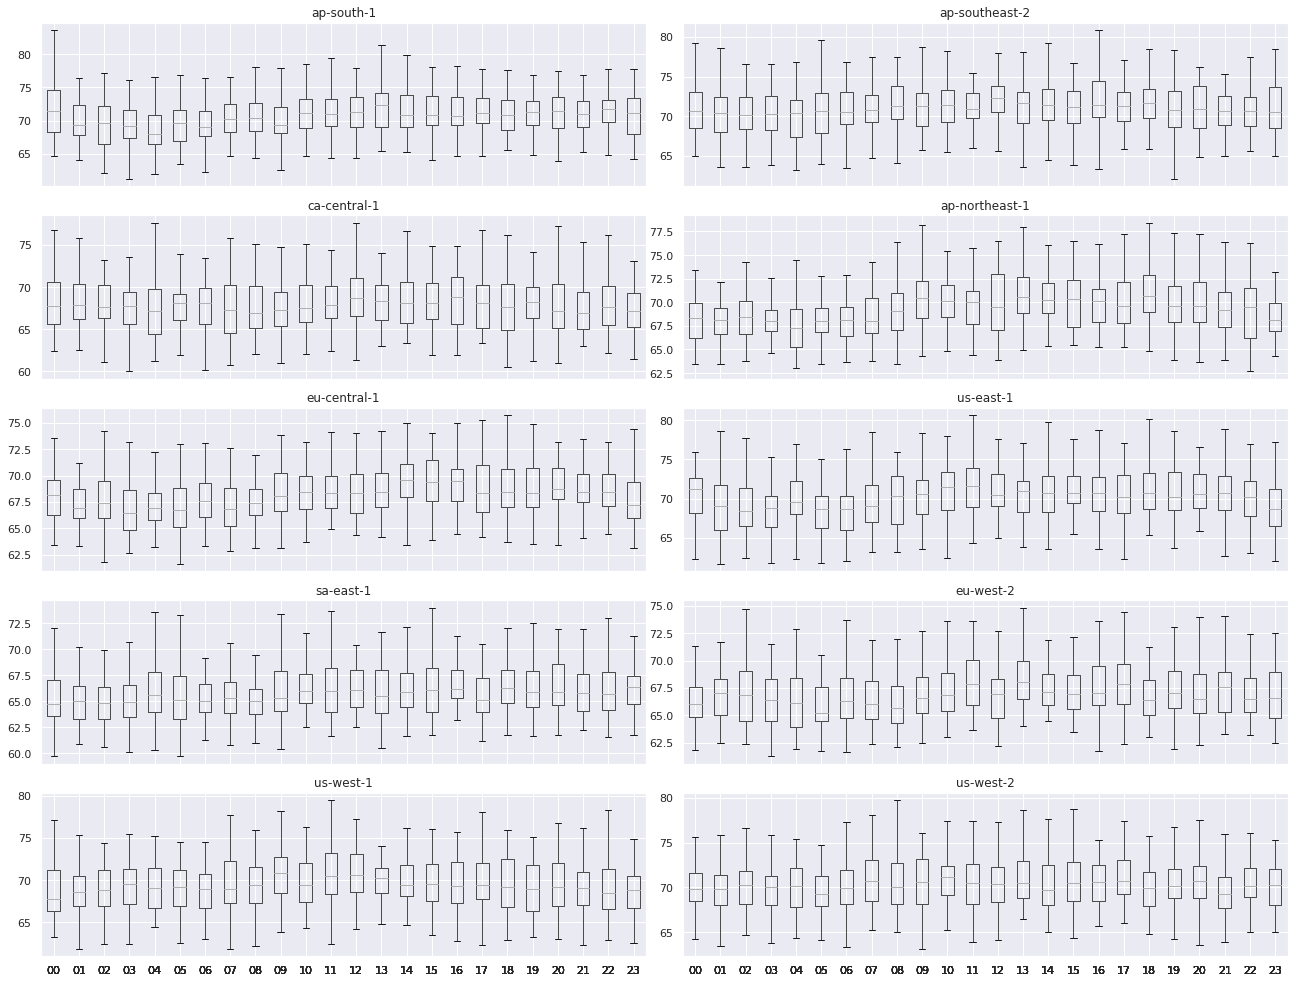

In [134]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)
from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in aws_hourly_decomposes:
    boxplot_hourly([decomp], axis[cax], decomp['region'], 'observed')
    cax += 1
    
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_observed_hourly_aws'])

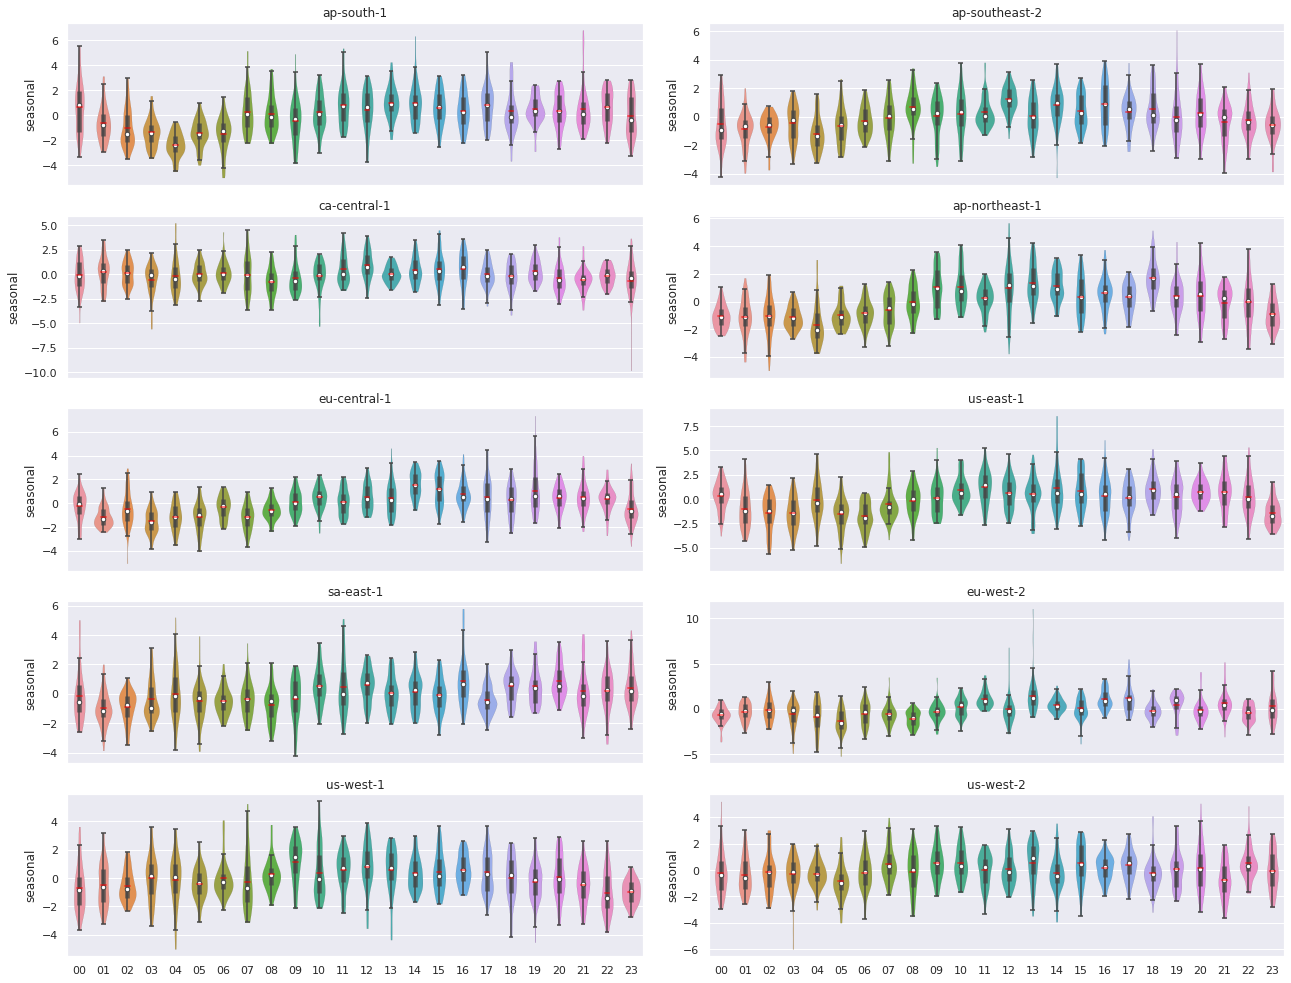

In [133]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)
from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in aws_hourly_decomposes:
    violinplot_hourly([decomp], axis[cax], decomp['region'])
    cax += 1
    
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_hourly_aws_violin'])

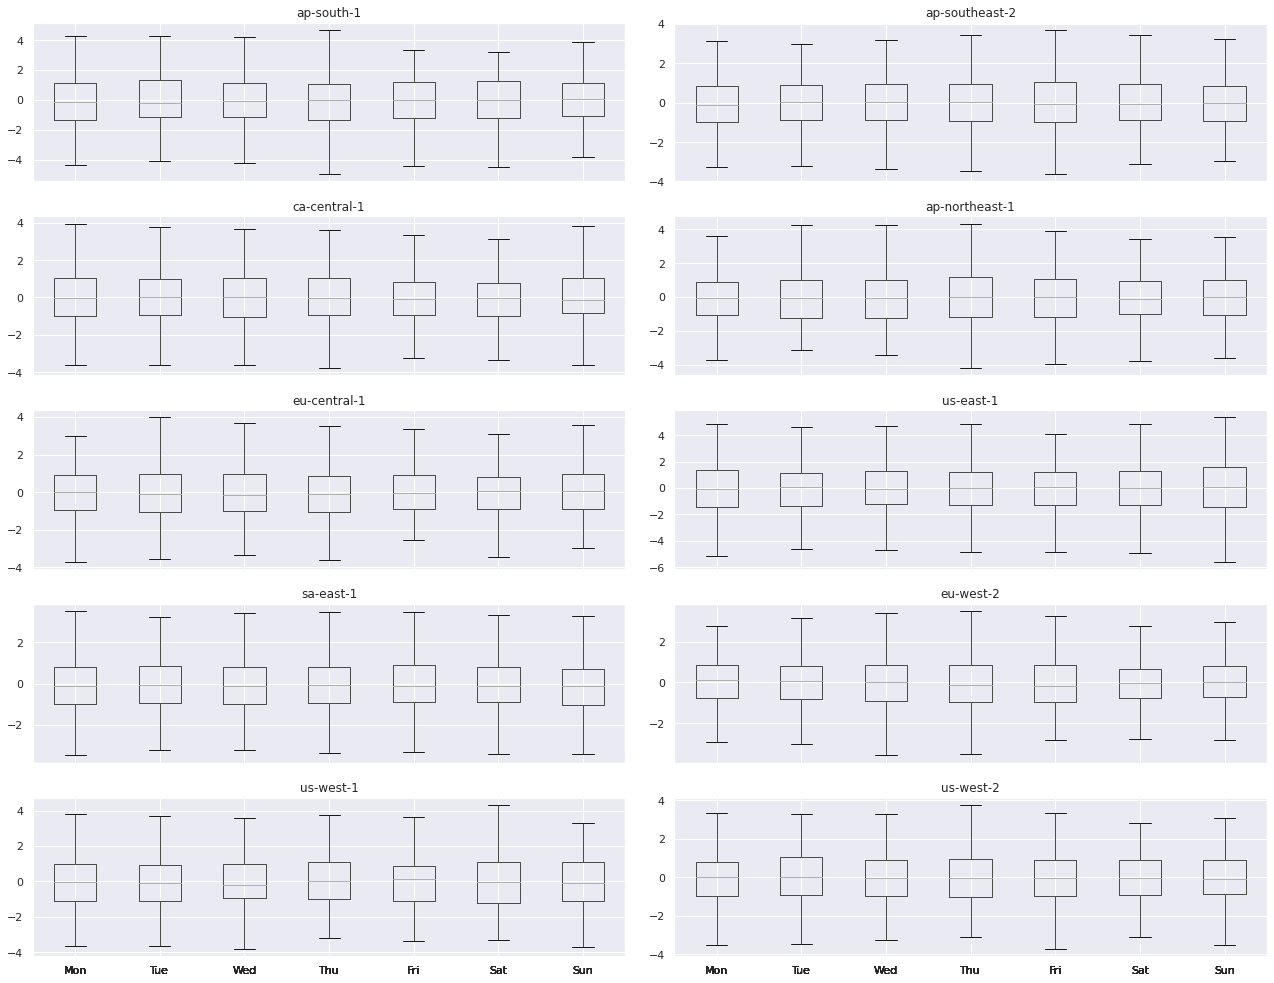

In [50]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)
from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in aws_hourly_decomposes:
    boxplot_daily([decomp], axis[cax], decomp['region'])
    cax += 1
    
axis[9].set_xticklabels(10*['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_daily_aws'])

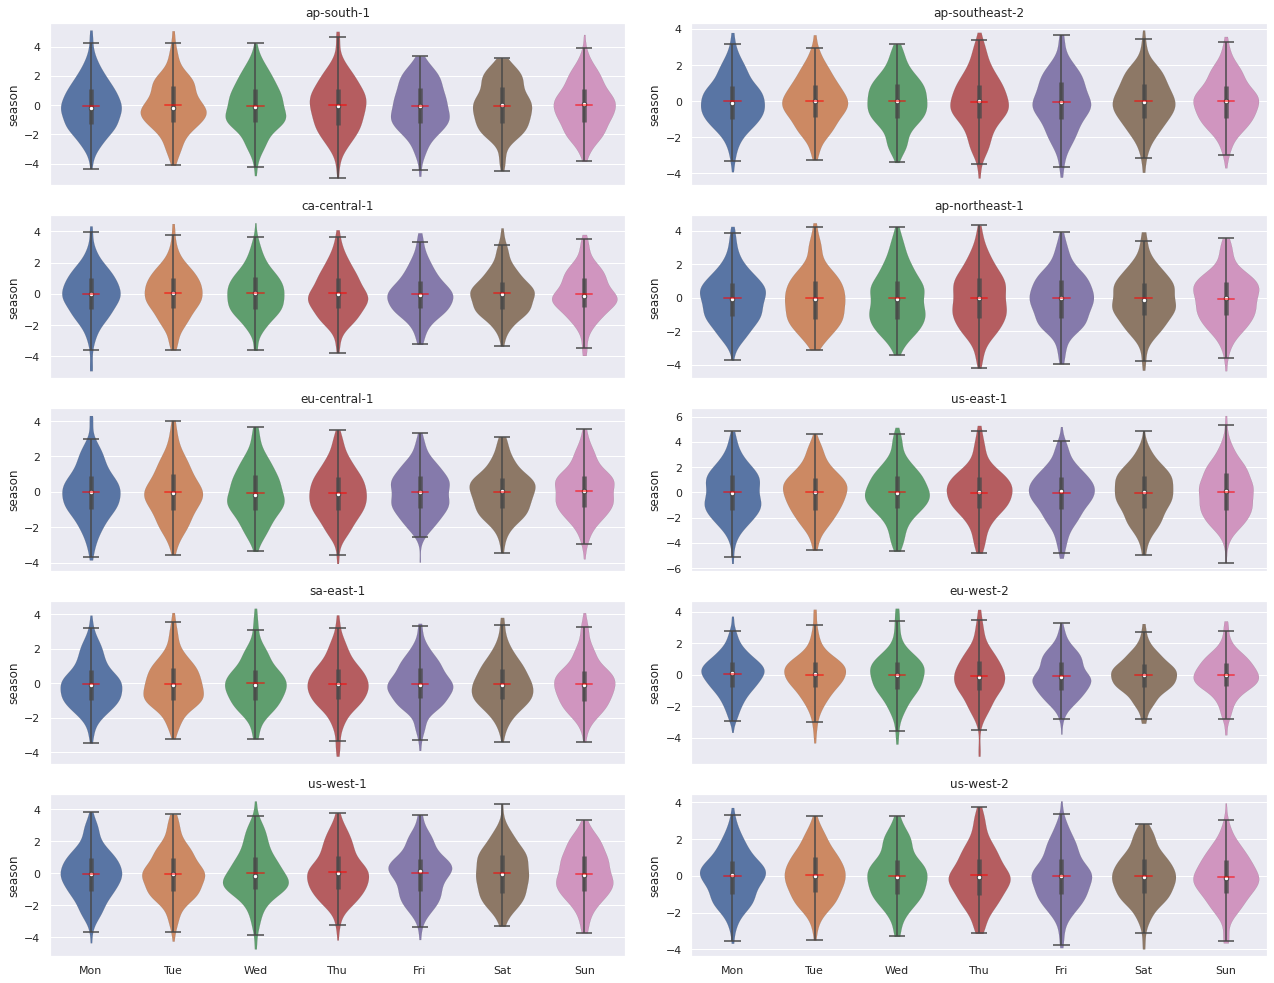

In [51]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)
from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in aws_hourly_decomposes:
    violinplot_daily([decomp], axis[cax], decomp['region'])
    cax += 1
    
axis[9].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_daily_aws_violin'])

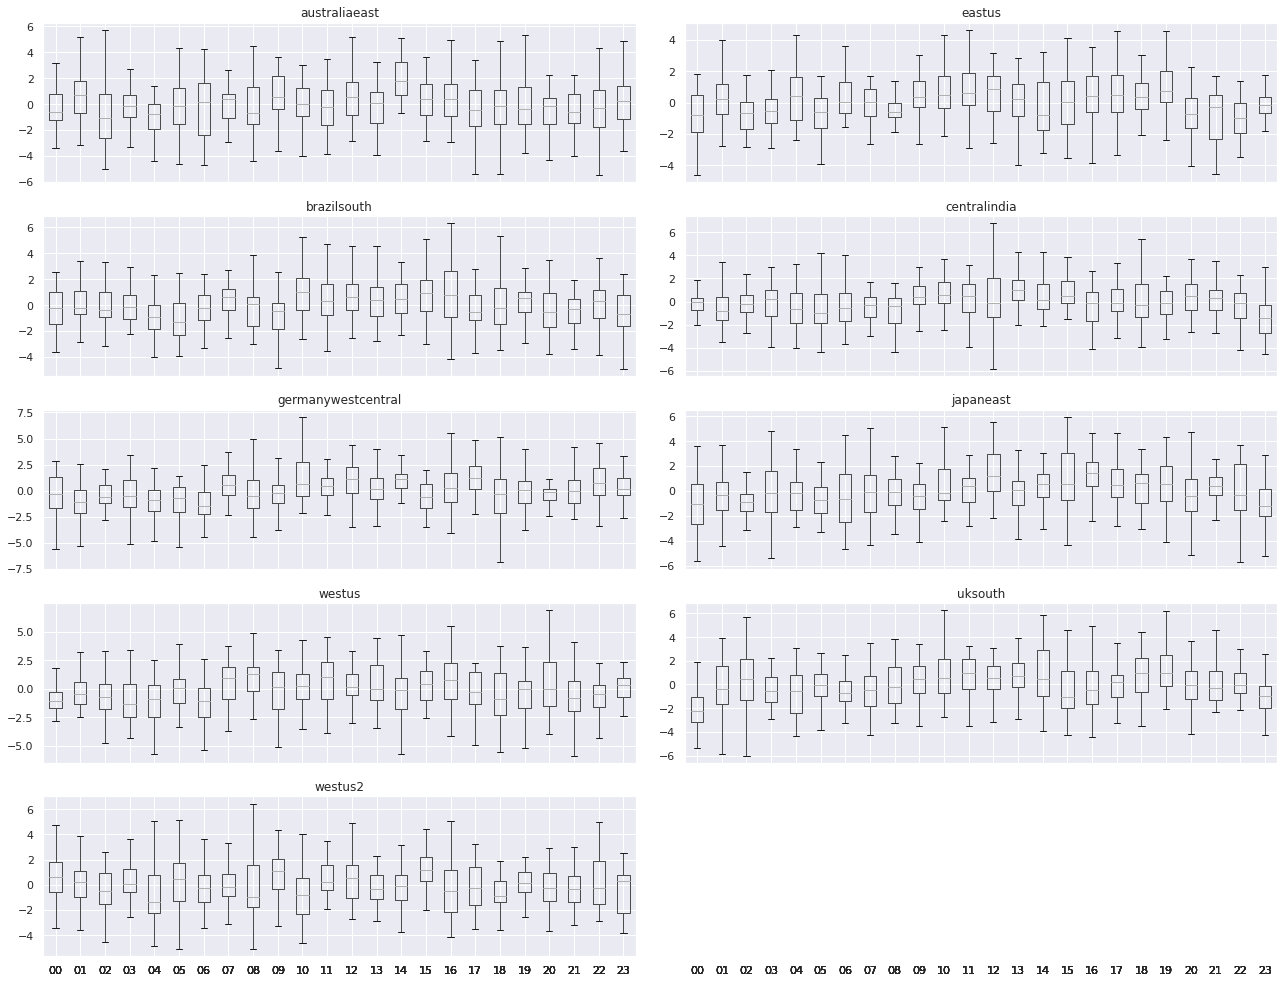

In [62]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)

from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in azure_hourly_decomposes:
    boxplot_hourly([decomp], axis[cax], decomp['region'])
    cax += 1

# remove as only 9 regions
axis[9].set_facecolor('none')
axis[9].set_yticks([])
    
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_hourly_azure'])

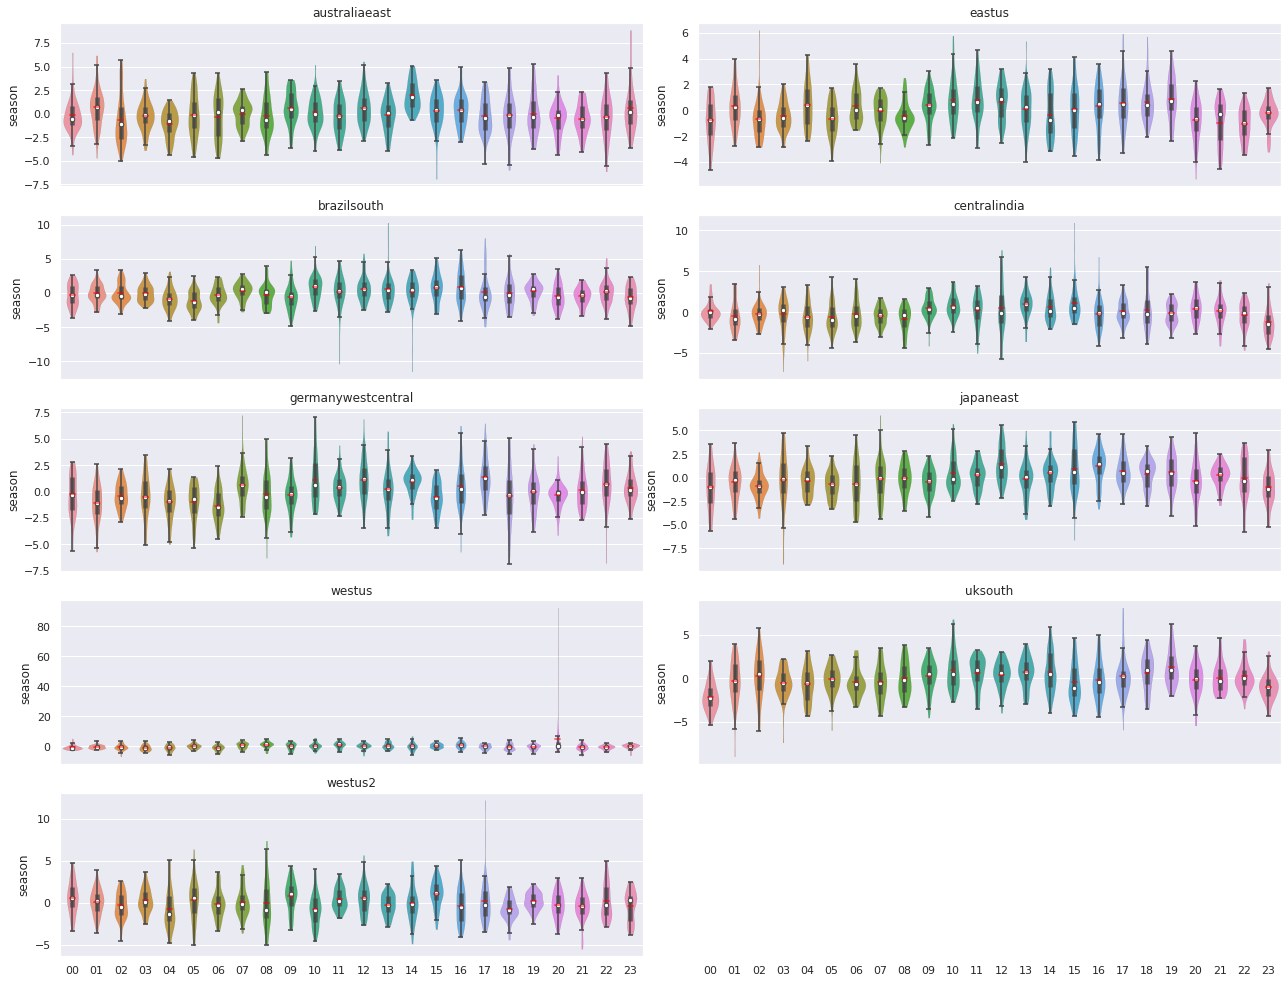

In [64]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)

from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in azure_hourly_decomposes:
    violinplot_hourly([decomp], axis[cax], decomp['region'])
    cax += 1

# remove as only 9 regions
axis[9].set_facecolor('none')
axis[9].set_yticks([])

fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_hourly_azure_violin'])

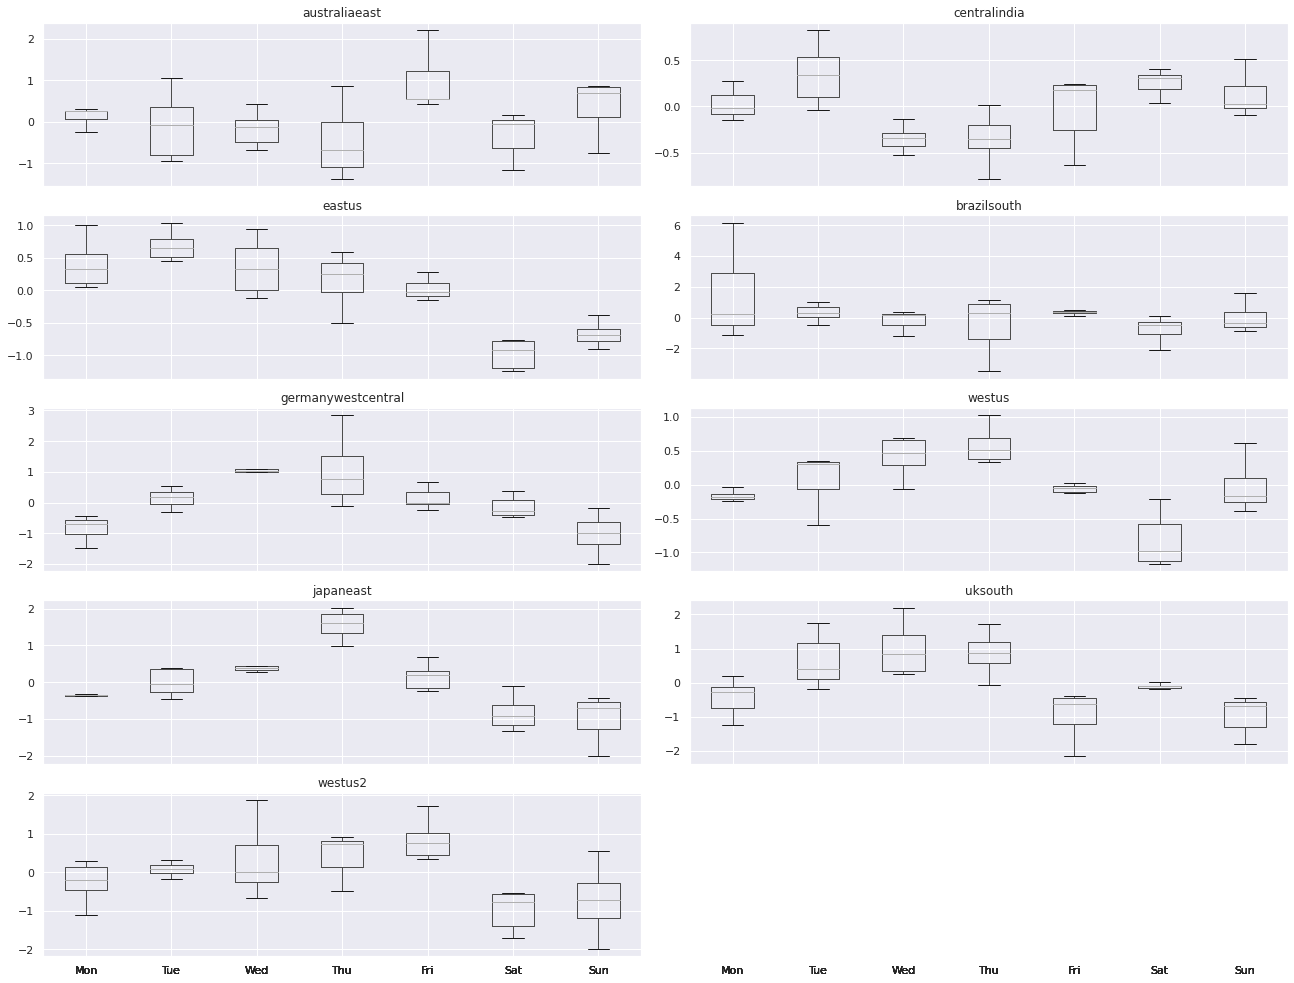

In [65]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)

from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in azure_daily_decomposes:
    boxplot_daily([decomp], axis[cax], decomp['region'])
    cax += 1
axis[0].set_xticklabels(9*['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

# remove as only 9 regions
axis[9].set_facecolor('none')
axis[9].set_yticks([])

fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_daily_azure'])

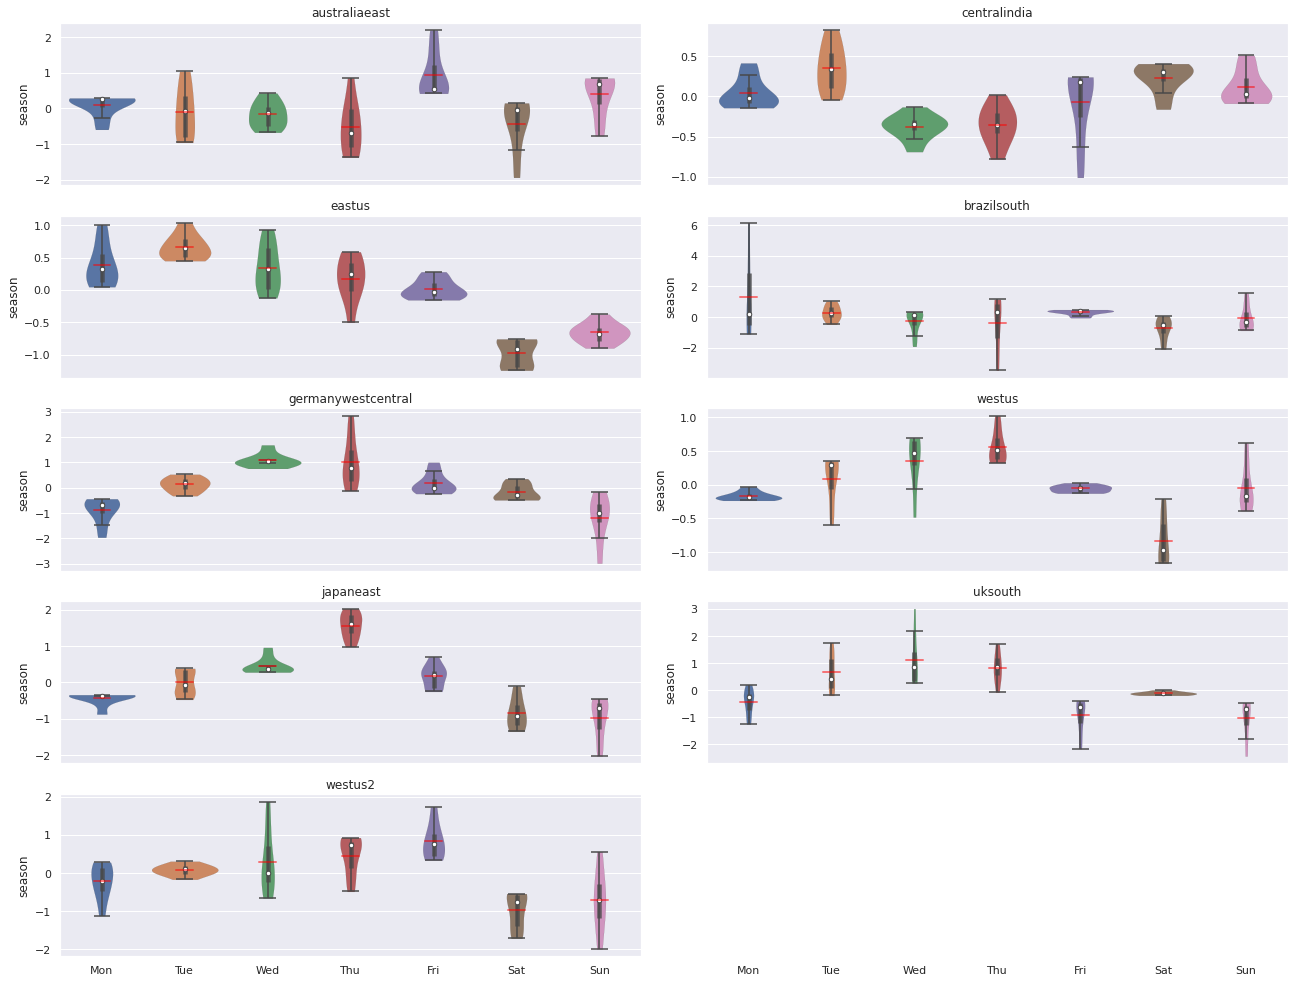

In [67]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)

from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in azure_daily_decomposes:
    violinplot_daily([decomp], axis[cax], decomp['region'])
    cax += 1

# remove as only 9 regions
axis[9].set_facecolor('none')
axis[9].set_yticks([])

axis[0].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_daily_azure_violinplot'])

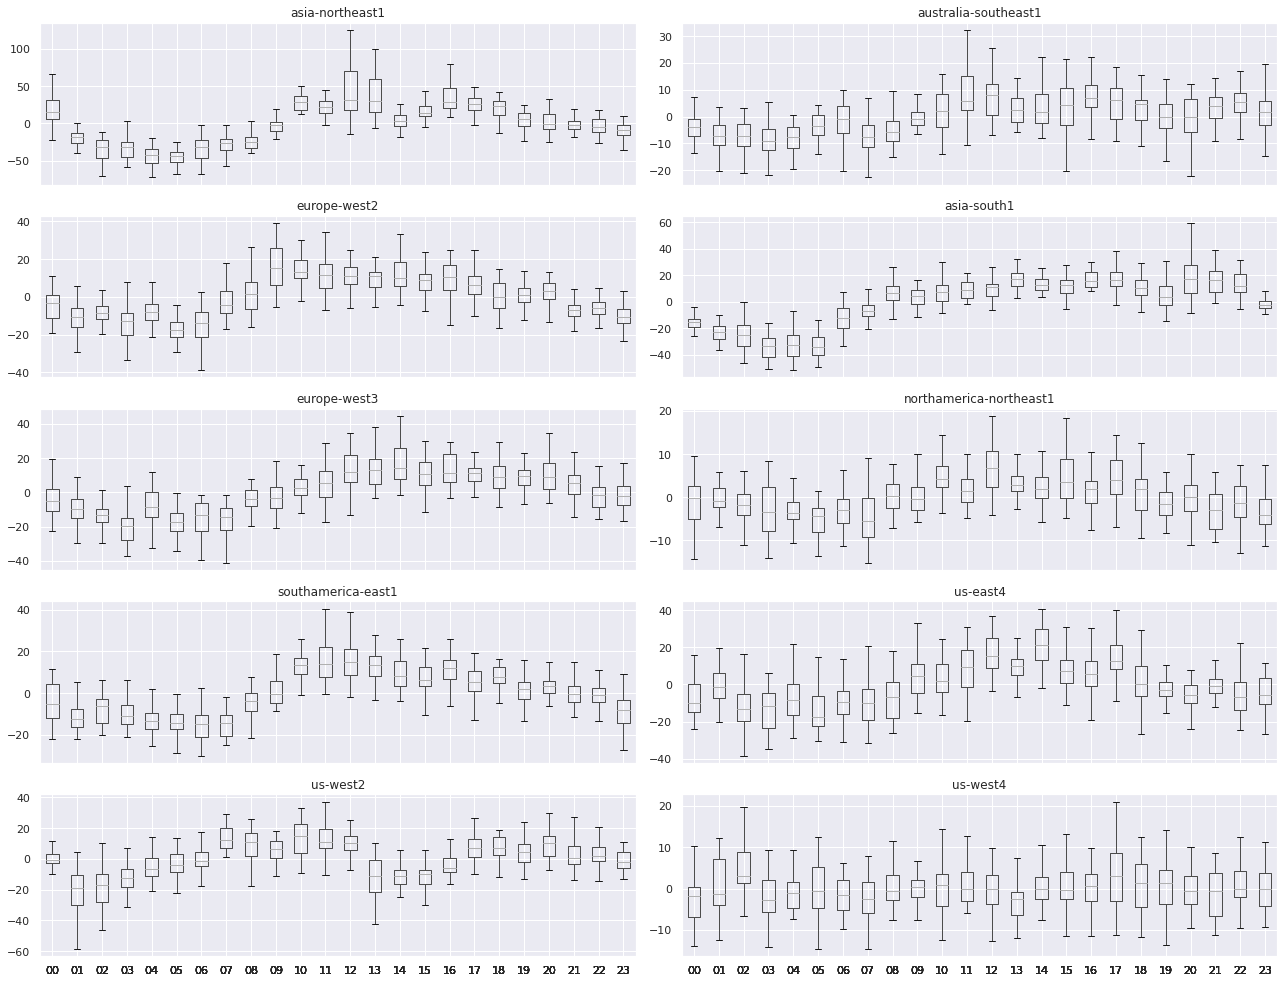

In [69]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)

from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in gcp_hourly_decomposes:
    boxplot_hourly([decomp], axis[cax], decomp['region'])
    cax += 1
    
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_hourly_gcp'])

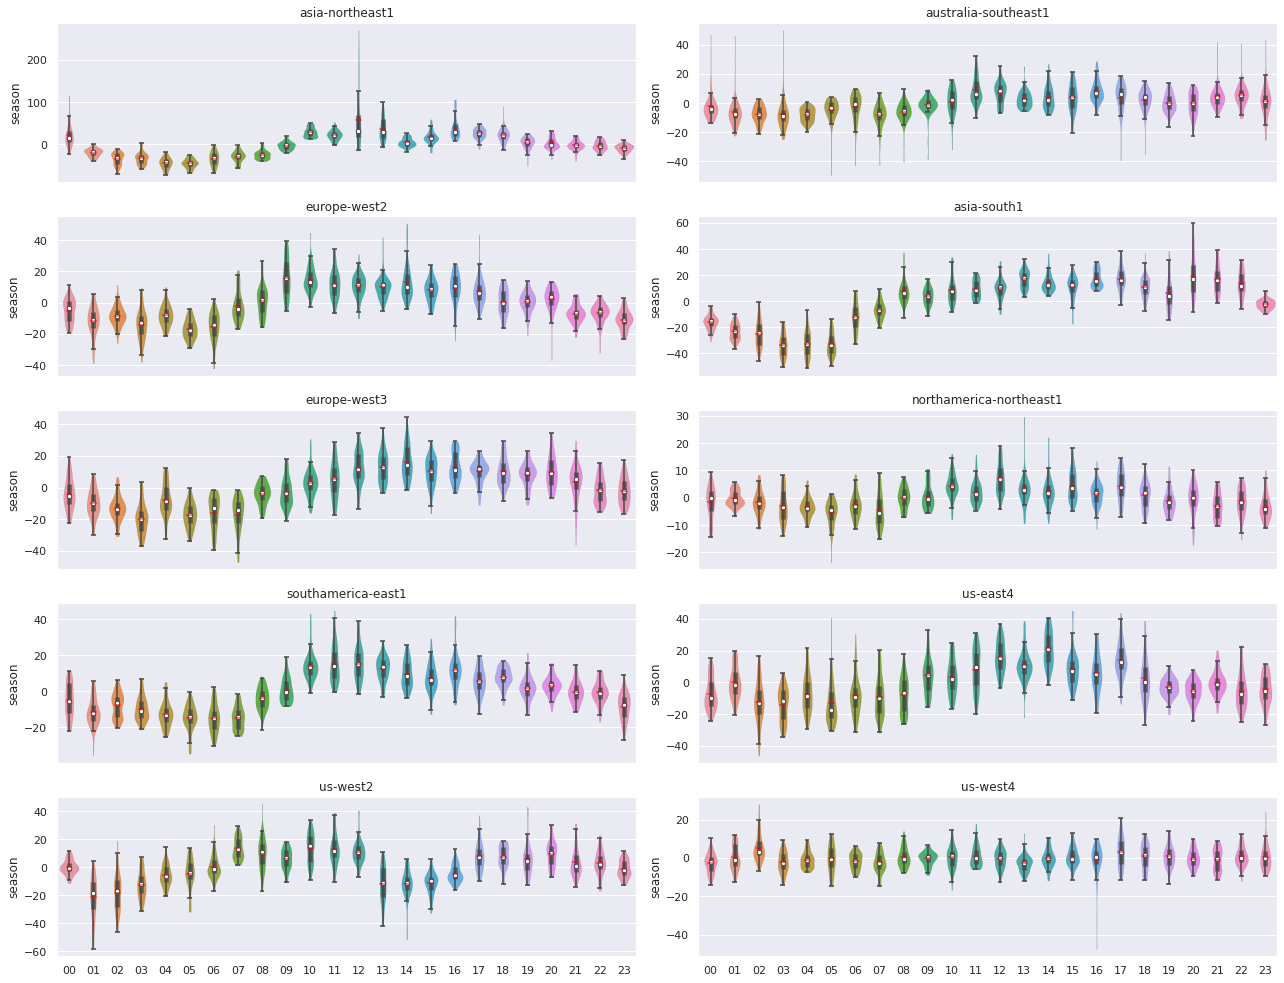

In [71]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)

from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in gcp_hourly_decomposes:
    violinplot_hourly([decomp], axis[cax], decomp['region'])
    cax += 1
    
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_hourly_gcp_violin'])

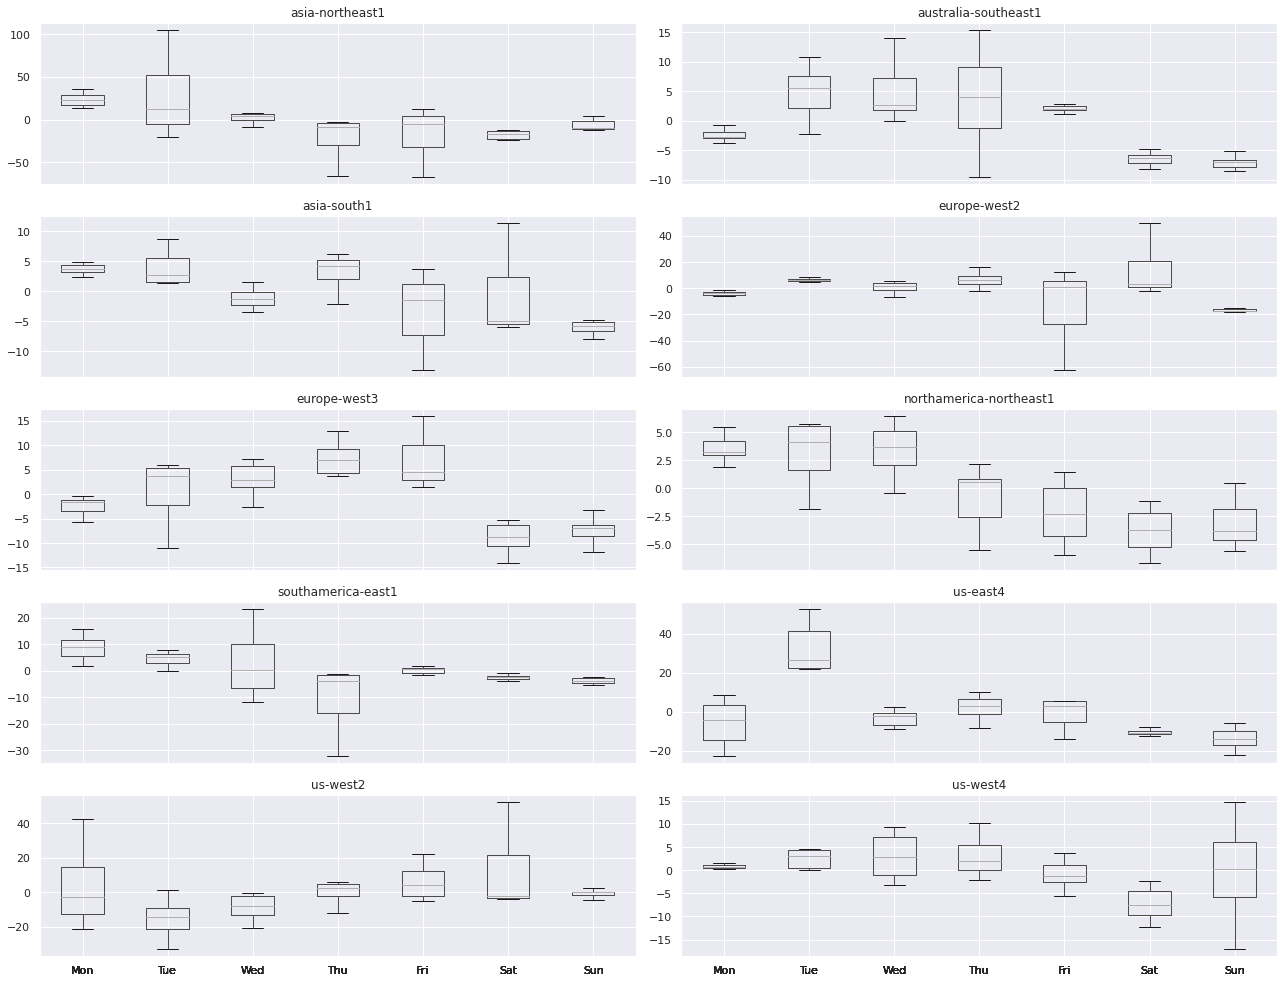

In [72]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)

from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in gcp_daily_decomposes:
    boxplot_daily([decomp], axis[cax], decomp['region'])
    cax += 1
    
axis[9].set_xticklabels(10*['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_daily_gcp'])

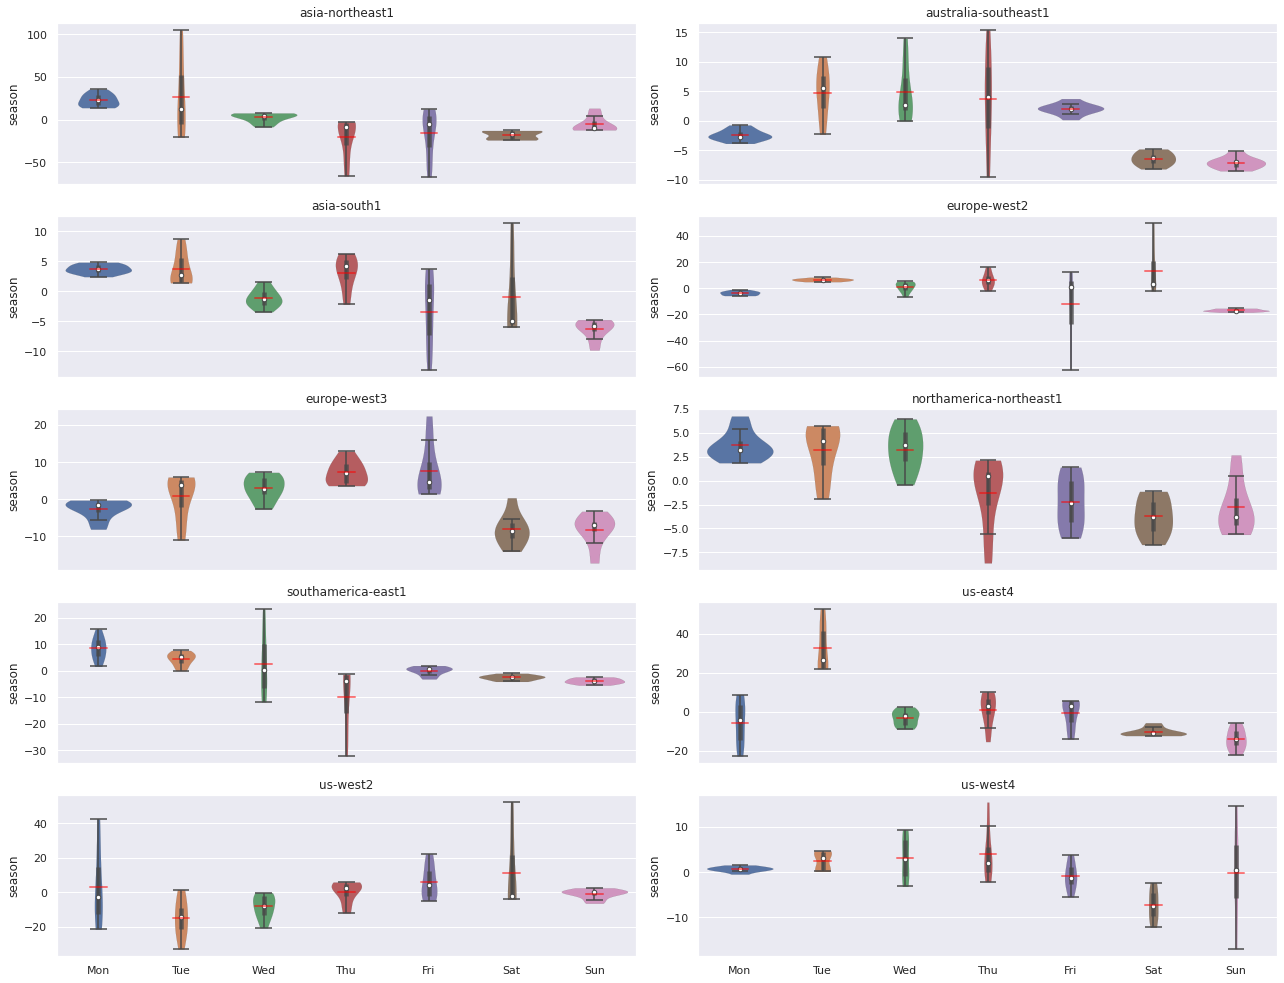

In [73]:
fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)

from itertools import chain
axis = list(chain.from_iterable(axis))

cax = 0
for decomp in gcp_daily_decomposes:
    violinplot_daily([decomp], axis[cax], decomp['region'])
    cax += 1
    
axis[9].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'runtime_seasonal_daily_gcp_violin'])

In [21]:
def output_casetable(casetab):
    output = ""

    # output += r'\begin{table}[]\begin{tabular}{lll} &  &  \\ &  &  \\ &  & \end{tabular}\end{table}'
    output += r'\begin{table}[h]\begin{tabular}{ll|cccc||cccc} '+ "\n"
    output += r' Provider & Region & \multicolumn{4}{c||}{Case Hourly} & \multicolumn{4}{c}{Case Daily} \\' + "\n"
    output += r'          &        & 1 & 2 & 3 & 4 & 1 & 2 & 3 & 4  \\' + "\n"
    for provider, regions in casetab.items():
        grp = provider
        
        for region, cases in regions.items():
            # print(provider, region, cases['hourly'], cases['daily'])
            hourly_case_1 = ""
            if cases['hourly'] == "case_1":
                hourly_case_1 = "X"
            hourly_case_2 = ""
            if cases['hourly'] == "case_2":
                hourly_case_2 = "X"
            hourly_case_3 = ""
            if cases['hourly'] == "case_3":
                hourly_case_3 = "X"
            hourly_case_4 = ""
            if cases['hourly'] == "case_4":
                hourly_case_4 = "X"
            
            
            daily_case_1 = ""
            if cases['daily'] == "case_1":
                daily_case_1 = "X"
            daily_case_2 = ""
            if cases['daily'] == "case_2":
                daily_case_2 = "X"
            daily_case_3 = ""
            if cases['daily'] == "case_3":
                daily_case_3 = "X"
            daily_case_4 = ""
            if cases['daily'] == "case_4":
                daily_case_4 = "X"
            
            line = ""
            line += f' {grp} & {region} & {hourly_case_1} & {hourly_case_2} & {hourly_case_3} & {hourly_case_4}'
            line += f' &'
            line += f' {daily_case_1} & {daily_case_2} & {daily_case_3} & {daily_case_4} \\\\'
            line += "\n"
            
            grp = ""
            output += line
        
    output += r'\end{tabular}\end{table}'
    return output
# Latex(output_casetable(casetab))

In [22]:
def create_casetab(hourly, daily):
    casetab = {}
    # Go Over Hourly
    for result in hourly:
        provider = result['provider']
        region = result['region']

        if provider not in casetab.keys():
            casetab[provider] = {}
        if region not in casetab[provider].keys():
            casetab[provider][region] = {}
            
        casetab[provider][region]['hourly'] = result['result']['stats_test']['case']
    # Go Over Hourly
    for result in daily:
        provider = result['provider']
        region = result['region']

        if provider not in casetab.keys():
            casetab[provider] = {}
        if region not in casetab[provider].keys():
            casetab[provider][region] = {}

        casetab[provider][region]['daily'] = result['result']['stats_test']['case']
    return casetab  

In [23]:
casetab = create_casetab(decomp_hourly, decomp_daily)
output = output_casetable(casetab)
Latex(output)

<IPython.core.display.Latex object>